# Add your name and details

**Date:** 

**Name:**  

**Education level:**

**Institute:**




# Galaxy Clusters & Protoclusters — Hands‑On Notebook
**Audience:** CAM-SUST Summer School on Astrophysics 2025 participants   
**Instructor:** S.L. Ahad, T. Bhowmick, A. Al-Imtiaz 

This notebook guides you through a sequence of small, focused tasks using a provided galaxy cluster member catalog.
You’ll compute colours, quality‑check the data, build stellar mass functions (SMFs) by cluster halo mass, split into red/blue populations, estimate uncertainties with bootstrap, explore red fraction, and finish with diagnostic “fingerprint” plots and an outlier hunt.

**Data expectation (one row per galaxy):**
- `cluster_id`: cluster identifier (string or int)
- `halo_mass`: host **cluster** mass (M500)
- `stellar_mass`: stellar mass in solar units (M☉); if you have `log10_stellar_mass`, set the mapping below
- `g_mag`, `r_mag`: apparent magnitudes
- `redshift`: galaxy redshift 
- `z_cl`: cluster redshift 

> If your column names differ, update the **Column mapping** cell below.

---

## Checklist of tasks (with the big ones in **bold**)

**Warm‑ups**
1. Compute colours & plot cluster and cluster member properties  

2. Per‑cluster summaries  

3. Colour–magnitude diagram (CMD) & red‑sequence identification

**Core analysis**

**4. Build cluster‑binned SMFs (total/red/blue)**  

**5. Bootstrap errorbars for SMFs**  

6. Red fraction vs halo mass  

7. Quenching‑efficiency proxy Δ(red fraction) vs. mass

**Comparative & diagnostics**

8. Cluster “fingerprint” plots (per‑cluster panels)  

9. Outlier hunt & short interpretation

Throughout the notebook, fill the **Report** sections (they’re scattered as “📝 Report” blocks). Be concise and tie claims to your figures.



In [1]:
# === Setup (run this first and make sure you have all the libraries) ===
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Optional utilities you may want:
from scipy.optimize import curve_fit

plt.rcParams.update({
    "figure.figsize": (6,5),
    "axes.grid": True,
    "axes.spines.top": False,
    "axes.spines.right": False,
    "font.size": 14,
})

print("Imports ready.")

Imports ready.


In [2]:

# === Column mapping (edit if your file uses different names) ===
COLS = {
    "cluster_id": "cl_id",
    "halo_mass": "halo_mass",
    "stellar_mass": "stellar_mass",   # If you ONLY have log10 mass, map to "log10_stellar_mass" below
    "log10_stellar_mass": None,       # e.g., set to "log10M" if present; if None, we compute from stellar_mass
    "g_mag": "g_mag",
    "r_mag": "r_mag",
    "redshift": "redshift",
}

# Red/blue colour cut (constant or z-dependent). Start simple:
COLOR_CUT = 0.9   # galaxies with (g-r) >= COLOR_CUT are "red"

# SMF binning (dex)
LOGM_BINS = np.arange(10.0, 12.5, 0.2)  # adjust to your data range

print("Column mapping and initial parameters set.")


Column mapping and initial parameters set.


In [3]:

# === Load your data ===

# Replace the path below with your CSV path.
# Expected columns per the mapping above.
PATH = "cluster_members.csv"  # TODO: replace with your data file

try:
    df = pd.read_csv(PATH, index_col=0)
    print(f"Loaded {len(df):,} rows from {PATH}")
except FileNotFoundError:
    print("⚠️ Could not find the data file at PATH. Please update PATH to your dataset.")
    df = pd.DataFrame()

# Apply mapping and compute useful columns
if not df.empty:
    # Standardize names (keep originals too)
    for k, v in COLS.items():
        if v is not None and v in df.columns:
            df[k] = df[v]

    # Compute log10 stellar mass if needed
    if COLS["log10_stellar_mass"] and COLS["log10_stellar_mass"] in df.columns:
        df["log10M"] = df[COLS["log10_stellar_mass"]].astype(float)
    elif "stellar_mass" in df.columns:
        df["log10M"] = np.log10(df["stellar_mass"].astype(float))
    else:
        raise ValueError("No stellar mass column found. Please set COLS['stellar_mass'] or COLS['log10_stellar_mass'].")

    # Colour
    df["g_r"] = df[COLS["g_mag"]] - df[COLS["r_mag"]]
    # Simple red/blue flag
    df["is_red"] = (df["g_r"] >= COLOR_CUT)

    # Quick sanity types
    for col in ["halo_mass", "redshift"]:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors="coerce")

df.head()


Loaded 1,647 rows from cluster_members.csv


,cl_id,halo_mass,z_cl,redshift,stellar_mass,g_mag,r_mag,cluster_id,log10M,g_r,is_red
0,169088,3.050000e+14,0.2356,0.2336,1.674943e+10,21.039,19.754,169088,10.224,1.285,True
1,169088,3.050000e+14,0.2356,0.2345,9.862795e+10,19.371,18.193,169088,10.994,1.178,True
2,169088,3.050000e+14,0.2356,0.2436,8.413951e+10,19.840,18.479,169088,10.925,1.361,True
3,169088,3.050000e+14,0.2356,0.2347,1.999862e+10,20.257,19.410,169088,10.301,0.847,False
4,169088,3.050000e+14,0.2356,0.2283,5.956621e+10,20.021,18.718,169088,10.775,1.303,True




## 📝 Report — Data preparation (a few bullet points)
- Data cuts 
- what does the above code do
- Did you update any part of the code above? Why?
- Anything you decided to exclude, and why

_Write your bullets below:_


In [4]:

# === Utilities (skeletons for you to complete) ===

def compute_smf(logm, bins):
    # Compute a (non-completeness-corrected) stellar mass function.
    # - Use np.histogram with provided bins.
    # - Convert counts to "per dex" by dividing by bin widths (np.diff(bins)).
    counts, edges = np.histogram(logm, bins=bins)
    widths = np.diff(edges)
    phi = counts / widths  # per dex
    centers = 0.5 * (edges[1:] + edges[:-1])
    return centers, phi, counts


def bootstrap_smf(logm, bins, n_boot=200, random_state=0):
    # Bootstrap uncertainties on the SMF by resampling galaxies with replacement.
    rng = np.random.default_rng(random_state)
    phis = []
    for _ in range(n_boot):
        sample = rng.choice(logm, size=len(logm), replace=True)
        _, phi, _ = compute_smf(sample, bins)
        phis.append(phi)
    phis = np.array(phis)
    phi_med = np.nanmedian(phis, axis=0)
    phi_lo = np.nanpercentile(phis, 16, axis=0)
    phi_hi = np.nanpercentile(phis, 84, axis=0)
    return phi_med, phi_lo, phi_hi


print("Utility scaffolding ready.")


Utility scaffolding ready.



## 1) Colours & histograms
- Compute `g_r = g - r` (already computed if you used the loader), flag NaNs and impossible values.
- Plot histograms of `log10(M*)`, `g_r`, and `redshift` for cluster member galaxies.
- plot histograms of `log10(halo_mass)`and `z_cl` for each cluster (**Warning: the halo mass and cluster z is provided for each cluster in each row of cluster member. Make sure to take only one member per cluster**)

- **Hints**: `pandas.Series.isna`, `numpy.isfinite`, `matplotlib.pyplot.hist`. For the cluster histogram, use the 'unique' elements from the required columns.


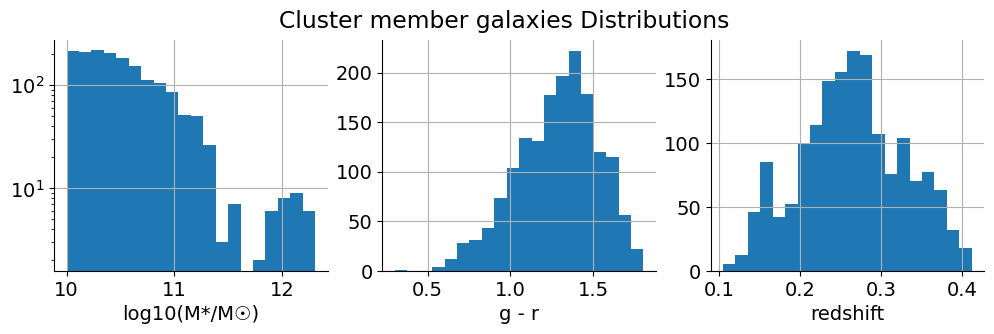

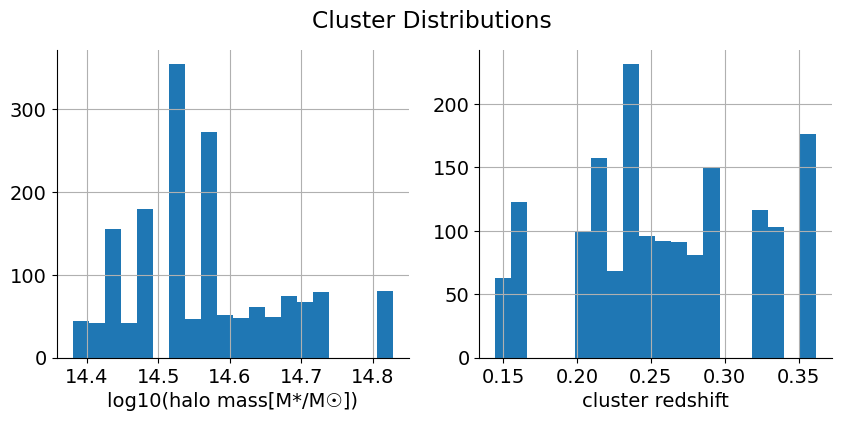

In [5]:

# cluster member properties

assert not df.empty, "Load your data first."


fig, axs = plt.subplots(1,3, figsize=(12,3))
axs[0].hist(df["log10M"].dropna(), bins=20)
axs[0].set_xlabel("log10(M*/M☉)")
axs[0].set_yscale('log')
axs[1].hist(df["g_r"].dropna(), bins=20)
axs[1].set_xlabel("g - r")
axs[2].hist(df["redshift"].dropna(), bins=20)
axs[2].set_xlabel("redshift")
fig.suptitle("Cluster member galaxies Distributions")
plt.show()


## Now make a histogram of cluster properties (log10(halo_mass) and z_cl). 
## First make the log version of halo mass, then use the previous histogram making code to make the target histogram
## some lines are added and commented already. Uncomment them and edit as required

# cluster_halo_mass = df['halo_mass'].unique()
# log_halo_mass = np.log10(cluster_halo_mass)

# cluster_redshift = df['redshift'].unique()

df["log10halo_mass"] = np.log10(df["halo_mass"].astype(float))

fig, axs = plt.subplots(1,2, figsize=(10,4))
axs[0].hist(df["log10halo_mass"].dropna(), bins=20)
axs[0].set_xlabel("log10(halo mass[M*/M☉])")
axs[1].hist(df['z_cl'].dropna(), bins=20) 
axs[1].set_xlabel("cluster redshift")

fig.suptitle("Cluster Distributions")
plt.show()




## 2) Per‑cluster summaries

- For each cluster, compute: number of members above a mass threshold, median `log10(M*)`, median colour, and **red fraction**. (the provided code does all of this already. read and understand the relevant bits)
- Visualize these summaries across clusters (bar or scatter).
- feel free to add any new disgnostics if you wnat.
- **Hints**: `DataFrame.groupby`, `agg`, and boolean masks for mass cuts.


,cluster_id,n_gal,med_logM,med_color,red_frac,halo_mass,z
0,169088,44,10.3955,1.2895,0.863636,3.050000e+14,0.23855
1,446974,52,10.4180,1.1530,0.826923,3.360000e+14,0.20405
2,620662,68,10.3835,1.2140,0.926471,3.410000e+14,0.23535
3,950439,48,10.4710,1.1680,0.916667,4.170000e+14,0.20265
4,955103,52,10.5045,1.3100,0.846154,3.920000e+14,0.26750


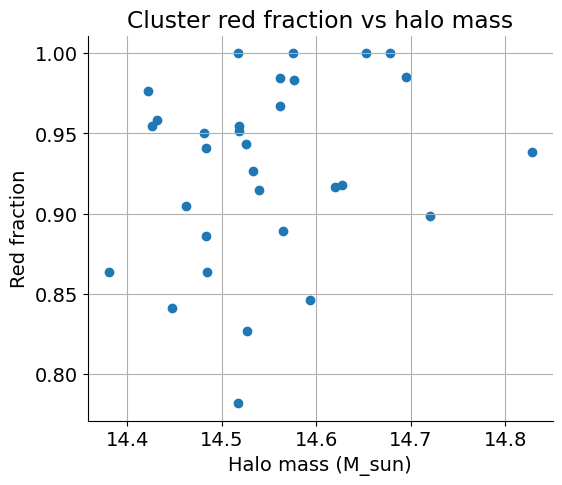

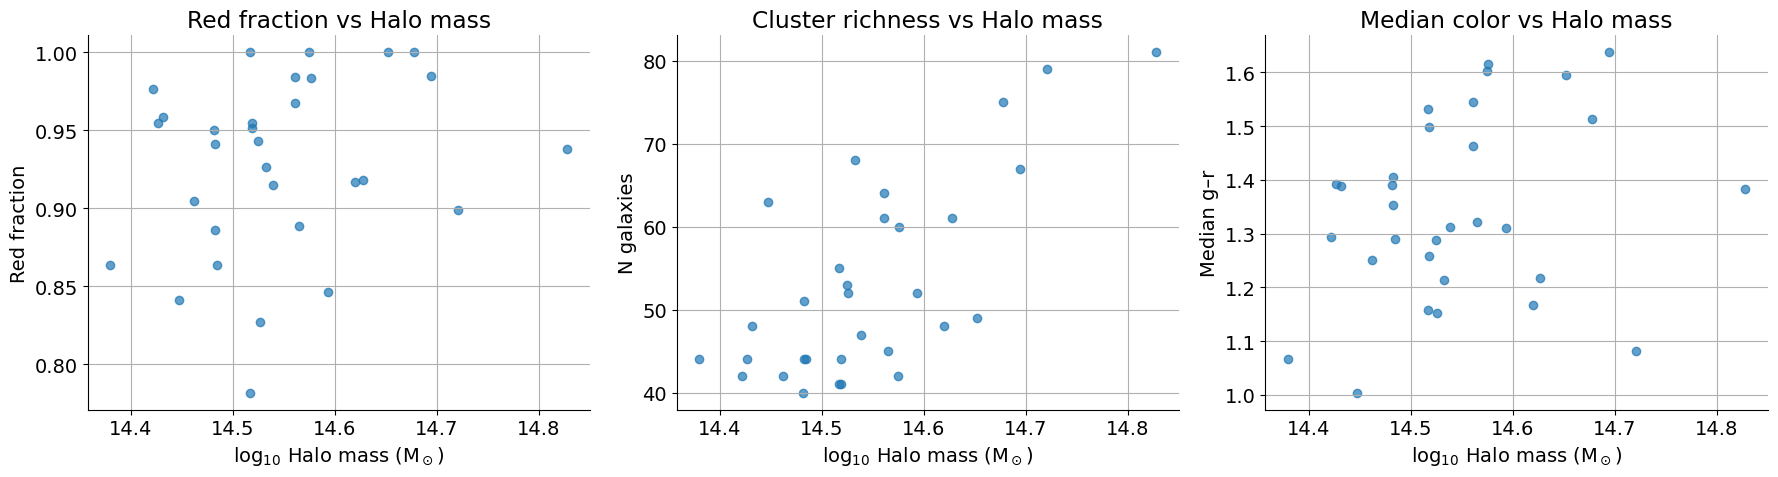

In [6]:

# TODO: Implement per-cluster table
M_MIN = 10.0  # dex; edit threshold as needed
d = df[df["log10M"] >= M_MIN].copy()

summary = (
    d.assign(red=lambda x: x["is_red"].astype(int))
     .groupby("cluster_id")
     .agg(n_gal=("log10M","size"),
          med_logM=("log10M","median"),
          med_color=("g_r","median"),
          red_frac=("red","mean"),
          halo_mass=("halo_mass","median"),
          z=("redshift","median"))
     .reset_index()
)
display(summary.head())

fig, ax = plt.subplots()
ax.scatter(np.log10(summary["halo_mass"]), summary["red_frac"])
ax.set_xlabel("Halo mass (M_sun)")
ax.set_ylabel("Red fraction")
ax.set_title("Cluster red fraction vs halo mass")
plt.show()


# Now make a 3-panel plot for Red fraction vs Halo mass, n_gal vs halo mass, and median color vs halo mass

fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharex=True)

# Panel 1: Red fraction vs halo mass
axes[0].scatter(np.log10(summary["halo_mass"]), summary["red_frac"], alpha=0.7)
axes[0].set_xlabel(r"log$_{10}$ Halo mass (M$_\odot$)")
axes[0].set_ylabel("Red fraction")
axes[0].set_title("Red fraction vs Halo mass")

# Panel 2: N_gal vs halo mass
axes[1].scatter(np.log10(summary["halo_mass"]), summary["n_gal"], alpha=0.7)
axes[1].set_xlabel(r"log$_{10}$ Halo mass (M$_\odot$)")
axes[1].set_ylabel("N galaxies")
axes[1].set_title("Cluster richness vs Halo mass")

# Panel 3: Median color vs halo mass
axes[2].scatter(np.log10(summary["halo_mass"]), summary["med_color"], alpha=0.7)
axes[2].set_xlabel(r"log$_{10}$ Halo mass (M$_\odot$)")
axes[2].set_ylabel("Median g–r")
axes[2].set_title("Median color vs Halo mass")

plt.tight_layout()
plt.show()


## 3) Colour–Magnitude Diagram & red‑sequence identification
- Make a CMD (`g-r` vs `r`) for one cluster. (already provided)
- identify the red sequence and mark it on the plot
- make similar plot for all the clusters

- **Bonus**: Fit a line to the red sequence and compute each galaxy’s **distance from the red sequence**. (simple code is provided in comments)
- Compare classification by distance vs a fixed colour cut.
- **Hints**: select one `cluster_id`; use `numpy.polyfit` (simple) or `scipy.optimize.curve_fit`.


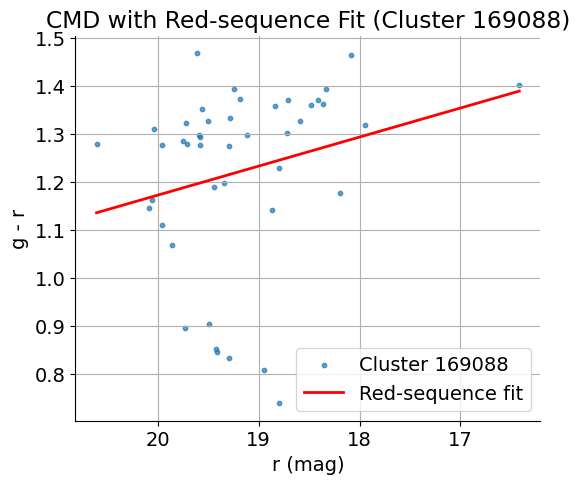

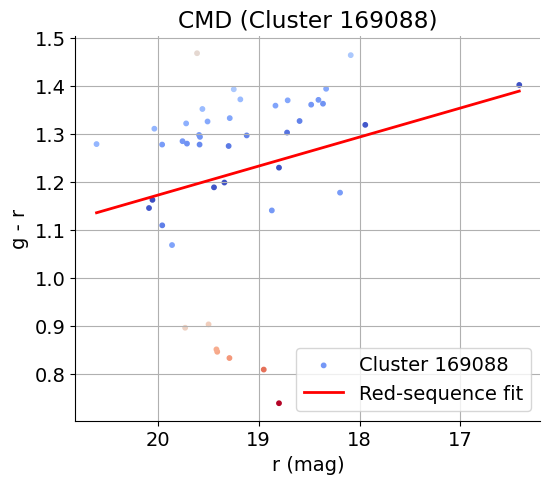

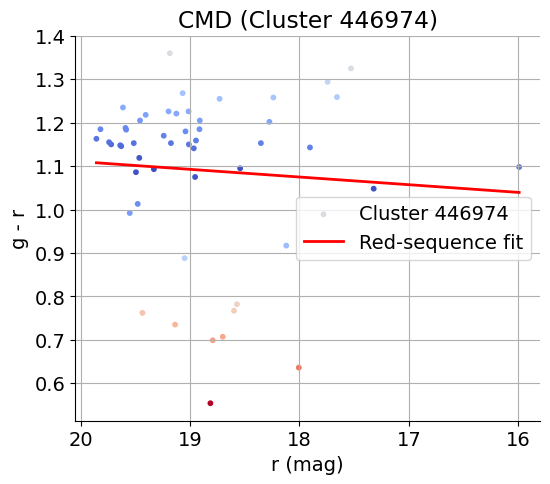

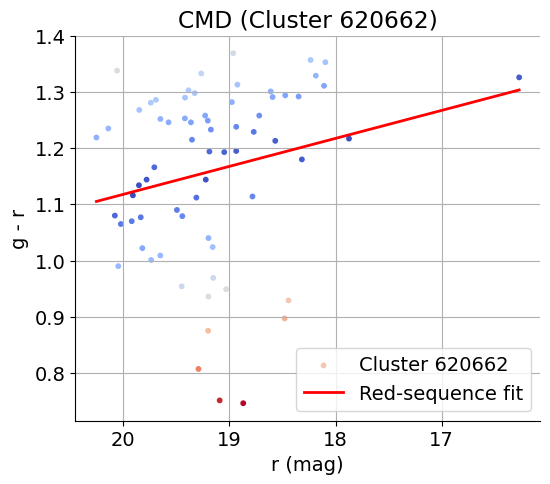

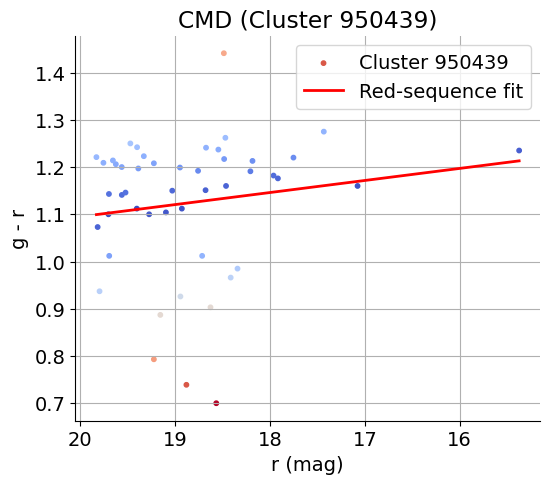

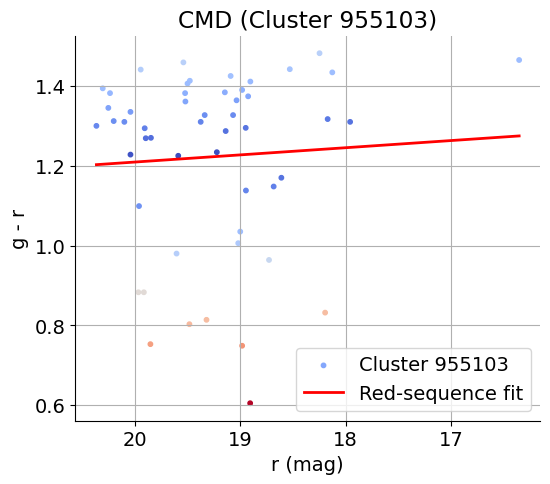

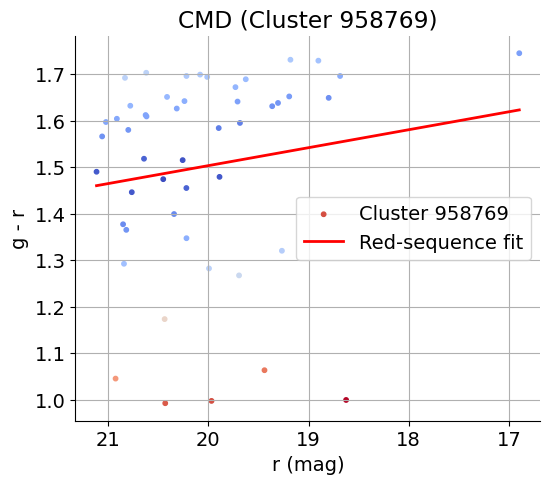

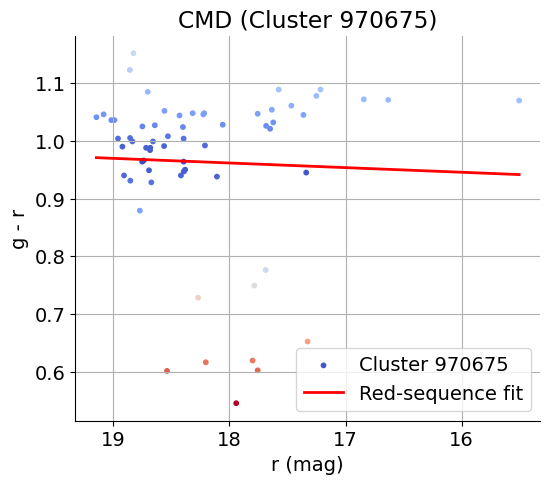

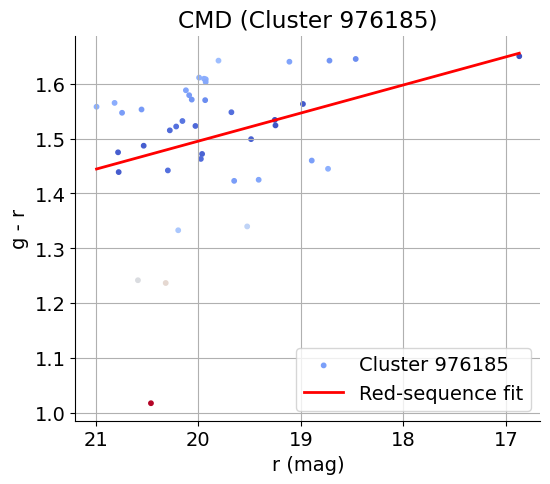

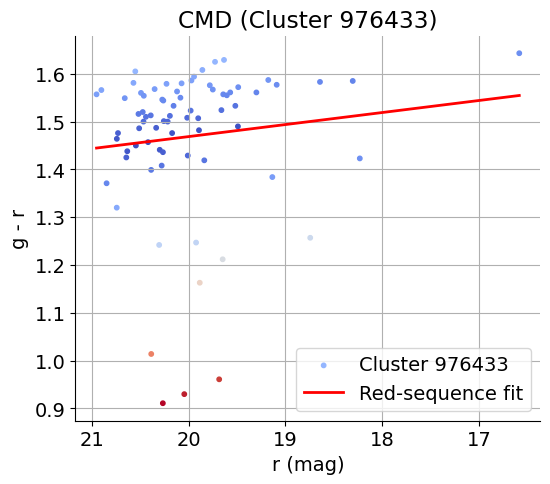

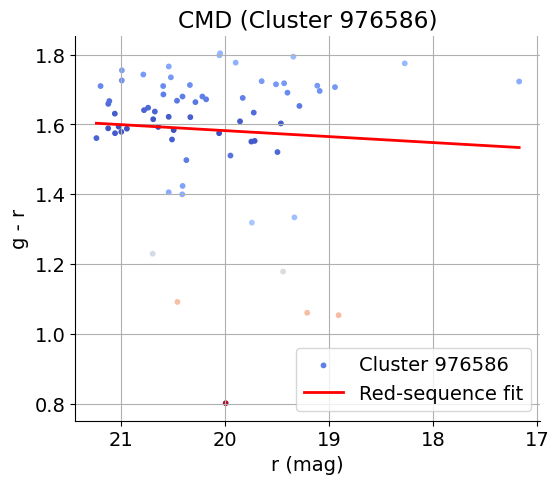

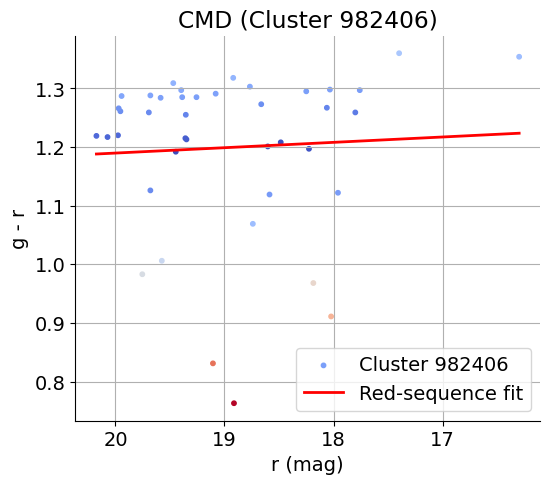

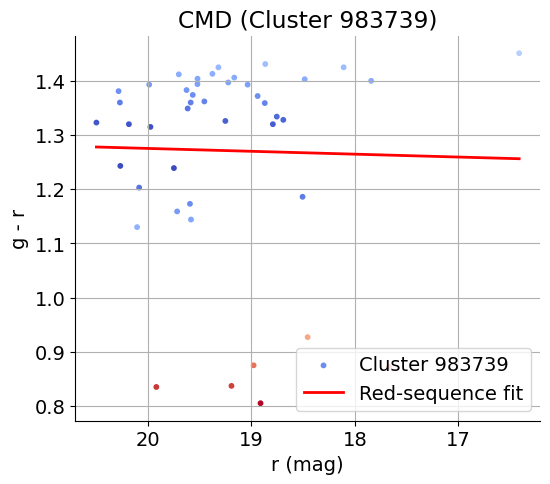

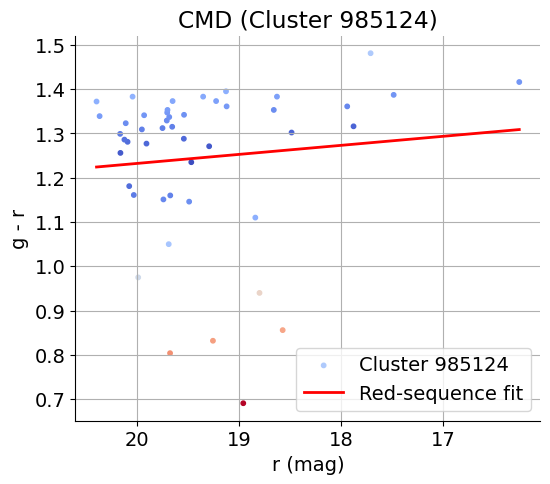

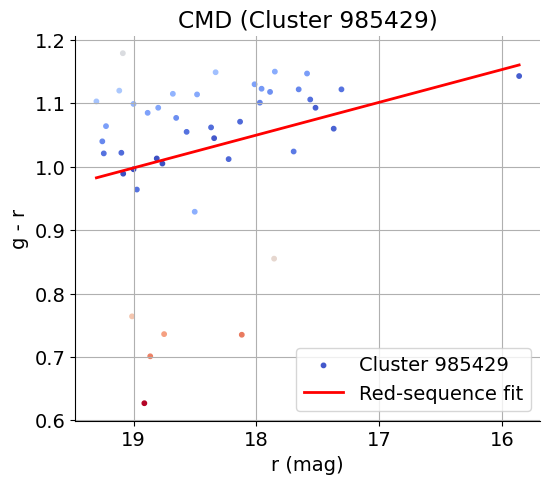

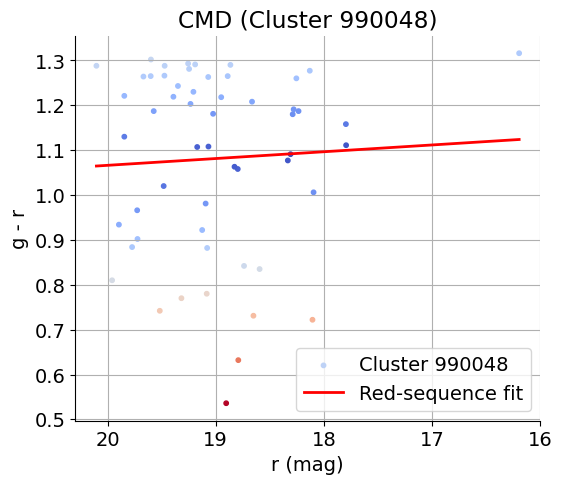

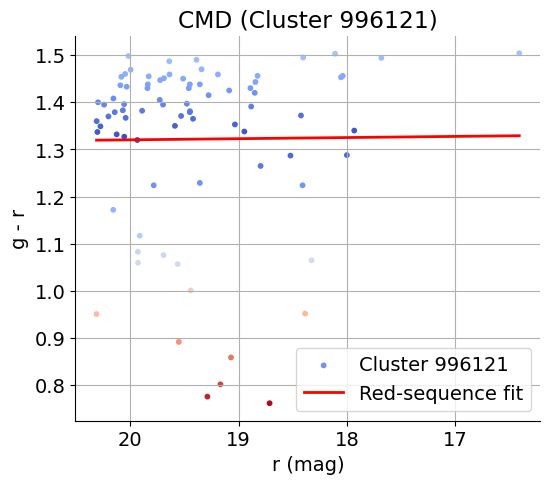

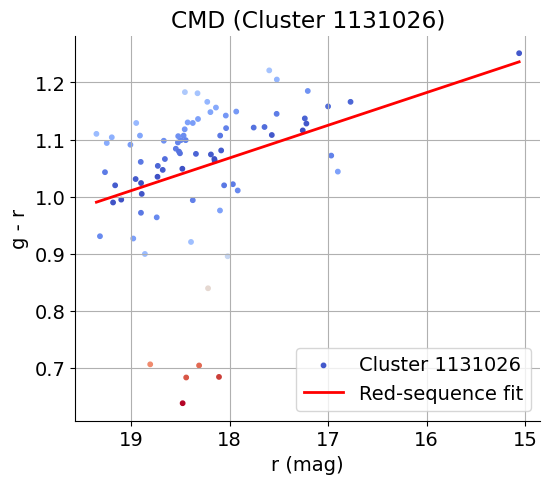

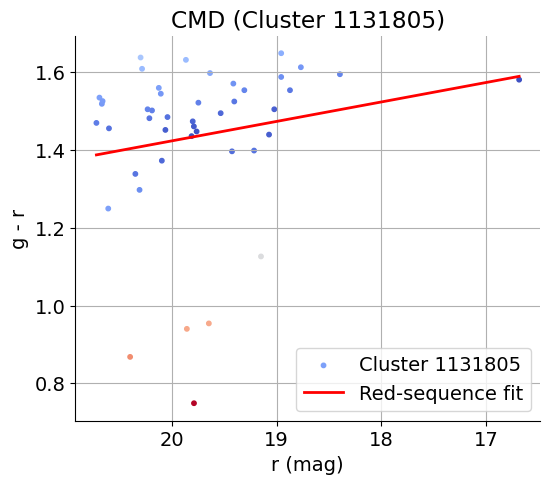

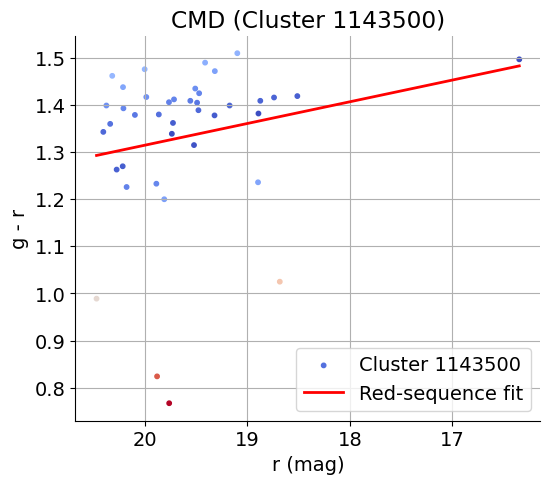

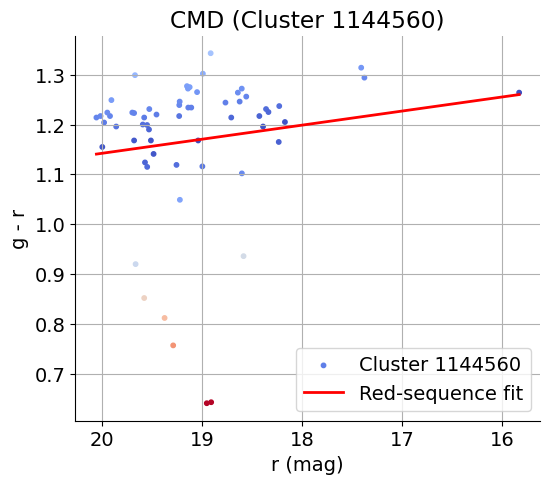

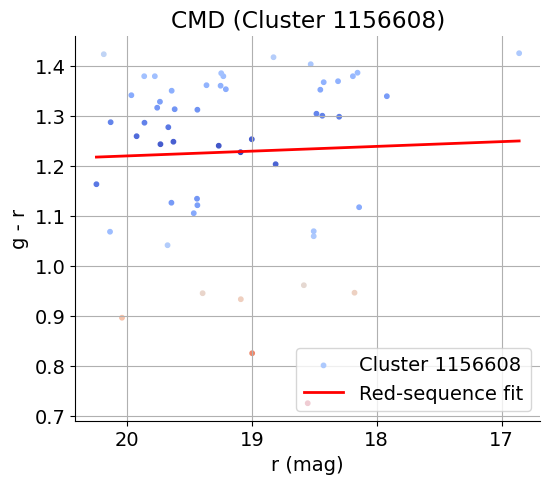

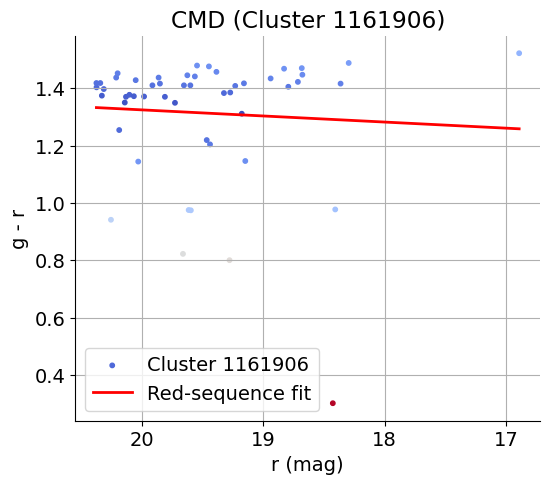

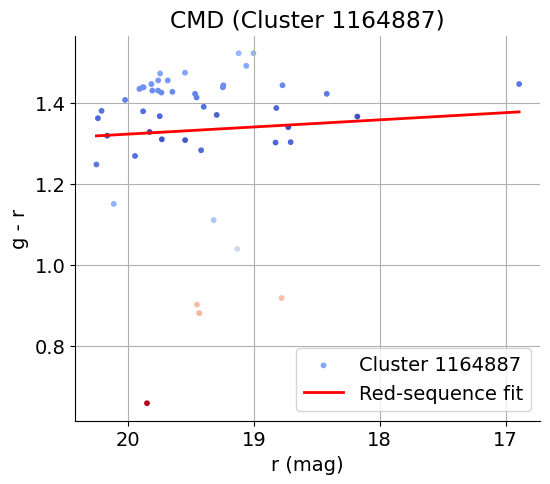

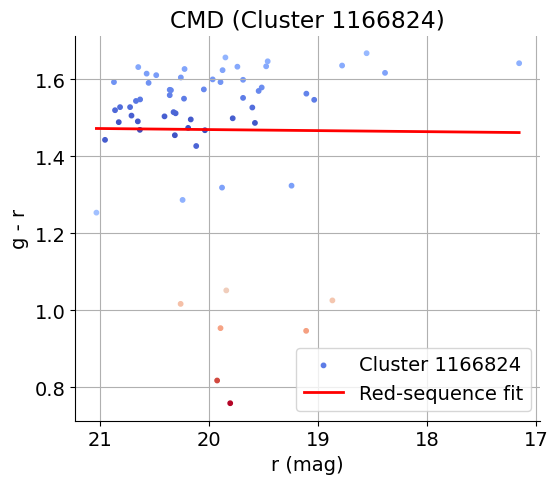

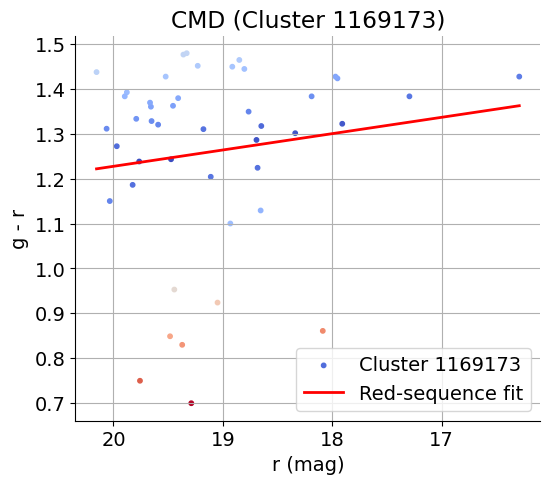

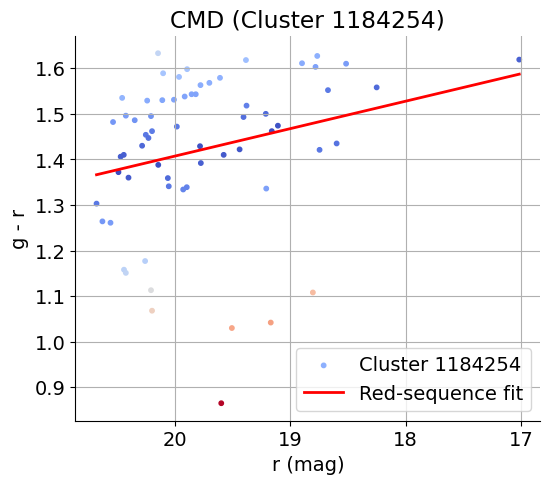

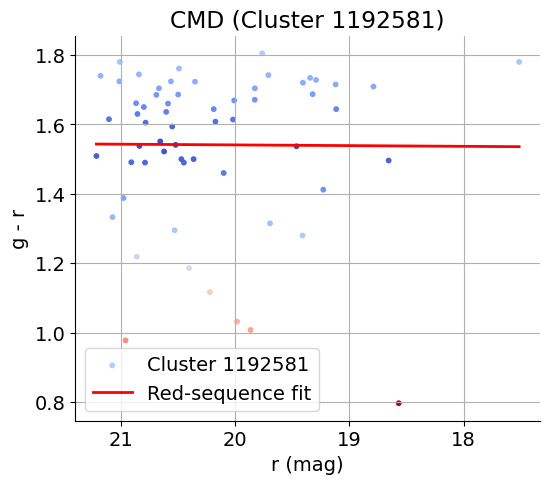

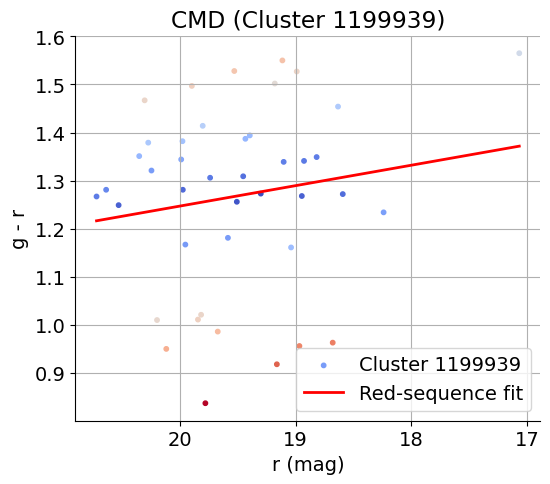

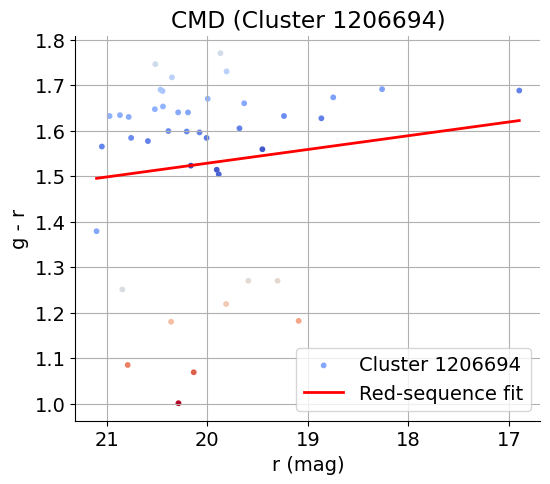

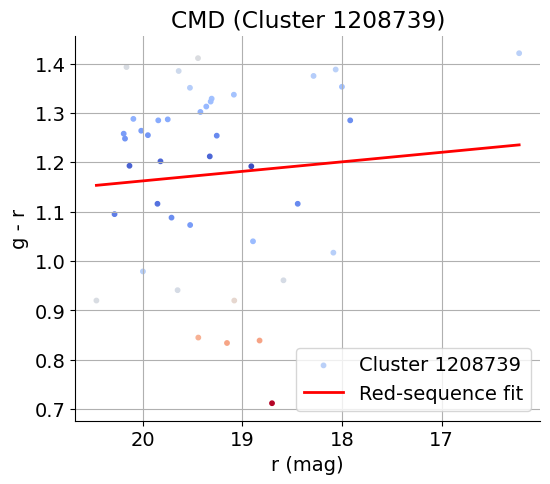

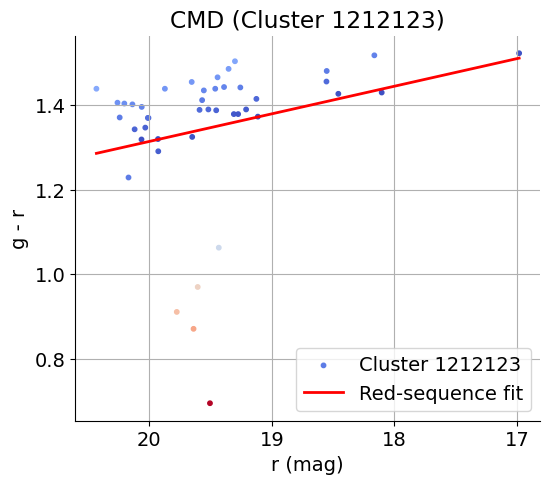

In [9]:
# TODO: Choose a cluster
cid_example = df["cluster_id"].iloc[0]
dc = df[df["cluster_id"] == cid_example].copy()

x = dc["r_mag"]
y = dc["g_r"]

# Fit y = a*x + b to the CMD
a, b = np.polyfit(x, y, 1)

# Make fit line
x_sorted = np.sort(x)
yfit_line = a * x_sorted + b

# Plot with fit
fig, ax = plt.subplots()
ax.scatter(x, y, s=10, alpha=0.7, label=f"Cluster {cid_example}")
ax.plot(x_sorted, yfit_line, color='red', lw=2, label="Red-sequence fit")
ax.set_xlabel("r (mag)")
ax.set_ylabel("g - r")
ax.invert_xaxis()  # optional: bright galaxies on the left
ax.legend()
ax.set_title(f"CMD with Red-sequence Fit (Cluster {cid_example})")
plt.show()


# Predicted color from red sequence:
dc["g_r_pred"] = a * dc["r_mag"] + b

# Distance from RS:
dc["d_rs"] = dc["g_r"] - dc["g_r_pred"]

dc.head()

# Classify galaxies within 0.05 mag of the RS as "RS members"
threshold = 0.05
dc["on_red_seq"] = np.abs(dc["d_rs"]) < threshold

fixed_cut = 0.7  # example g-r threshold
dc["red_fixedcut"] = dc["g_r"] > fixed_cut

for cid in df["cluster_id"].unique():
    dc = df[df["cluster_id"] == cid].copy()
    x = dc["r_mag"]
    y = dc["g_r"]

    a, b = np.polyfit(x, y, 1)
    dc["g_r_pred"] = a*dc["r_mag"] + b
    dc["d_rs"] = dc["g_r"] - dc["g_r_pred"]

    fig, ax = plt.subplots()
    ax.scatter(x, y, s=10, c=np.abs(dc["d_rs"]), cmap='coolwarm', label=f"Cluster {cid}")
    ax.plot(np.sort(x), a*np.sort(x) + b, color='red', lw=2, label="Red-sequence fit")
    ax.invert_xaxis()
    ax.set_xlabel("r (mag)")
    ax.set_ylabel("g - r")
    ax.legend()
    ax.set_title(f"CMD (Cluster {cid})")
    plt.show()



## 📝 Report — Getting familiarized with cluster galaxies
- Write short paragraphs on the tasks you did for this session 
- What did you notice about the cluster and cluster galaxy population from the histograms?
- What does red fraction signify? What are the red fractions in your sample indicating?
- Write about the red sequence of your cluster sample. Were they easy to identify? Why or why not? 
- Write about the blue cloud from your cluster sample.

_Write your bullets below:_


>


## 4) **SMFs by cluster halo mass bin** 

- Split clusters into **low / high** halo‑mass bins.
- For each bin, build SMFs for **all**, **red**, and **blue** galaxies.
- Use `compute_smf` to get binned counts; plot on the same axes.
- try different bin width and different halo mass split to see how that changes the sample
- Calculate the average halo mass in each halo mass bin and add to report


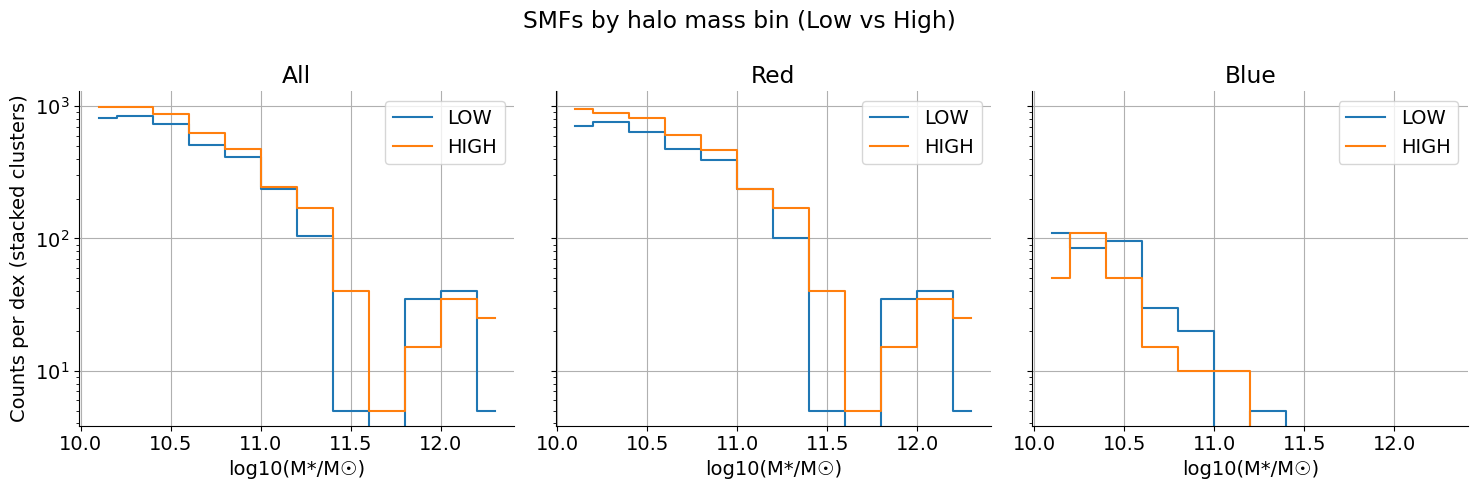

In [10]:
# === Low vs High halo-mass bins (median split) ===
clusters = (
    df.groupby("cluster_id")
      .agg(halo_mass=("halo_mass","median"))
      .reset_index()
)

# Split by the median halo mass (robust; no qcut edge issues)
hm_med = clusters["halo_mass"].median()
clusters["hm_bin"] = np.where(clusters["halo_mass"] <= hm_med, "low", "high")

df_hm = df.merge(clusters[["cluster_id","hm_bin"]], on="cluster_id", how="left")

fig, axs = plt.subplots(1, 3, figsize=(15, 5), sharey=True)
for i, tag in enumerate(["all", "red", "blue"]):
    ax = axs[i]
    for hm in ["low", "high"]:
        dsel = df_hm[df_hm["hm_bin"] == hm]
        if tag == "red":
            dsel = dsel[dsel["is_red"]]
        elif tag == "blue":
            dsel = dsel[~dsel["is_red"]]
        centers, phi, counts = compute_smf(dsel["log10M"], LOGM_BINS)
        ax.step(centers, phi, where="mid", label=hm.upper())
    ax.set_xlabel("log10(M*/M☉)")
    ax.set_yscale('log')

    if i == 0:
        ax.set_ylabel("Counts per dex (stacked clusters)")
    ax.set_title(tag.capitalize())
    ax.legend()

fig.suptitle("SMFs by halo mass bin (Low vs High)")
plt.tight_layout()
plt.show()



## 5) **Bootstrap errorbars for SMFs** (15 min)
- For one panel above (e.g., **all** galaxies), compute bootstrap medians and (16,84) percentiles for each halo‑mass bin.
- Overplot errorbars.
- Repeat process for the red and blue galaxies
- How do the errorbars compare for each sample?
- **Hints**: use `bootstrap_smf`; `matplotlib.pyplot.errorbar`.


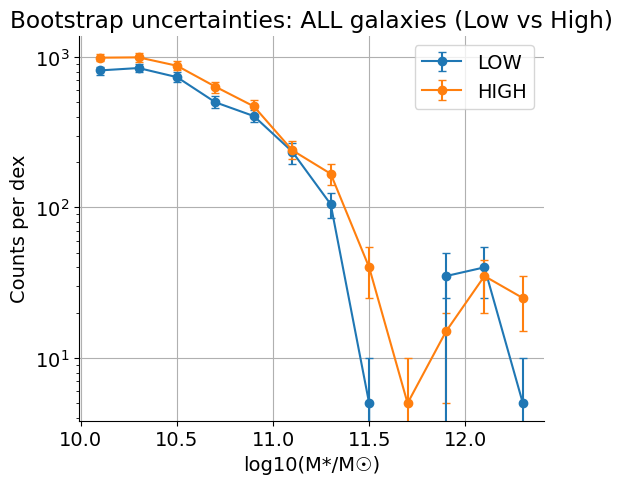

In [11]:
# === Bootstrap errorbars for SMFs (ALL galaxies; Low vs High only) ===
fig, ax = plt.subplots()
for hm in ["low", "high"]:
    dsel = df_hm[df_hm["hm_bin"] == hm]
    centers, _, _ = compute_smf(dsel["log10M"], LOGM_BINS)
    phi_med, phi_lo, phi_hi = bootstrap_smf(
        dsel["log10M"].values, LOGM_BINS, n_boot=300, random_state=42
    )
    yerr = np.vstack([phi_med - phi_lo, phi_hi - phi_med])
    ax.errorbar(centers, phi_med, yerr=yerr, fmt="o-", capsize=3, label=hm.upper())

ax.set_xlabel("log10(M*/M☉)")
ax.set_ylabel("Counts per dex")
ax.set_title("Bootstrap uncertainties: ALL galaxies (Low vs High)")
ax.set_yscale('log')
ax.legend()
plt.show()




## 📝 Report — SMF and bootsrap
- What did you notice about the SMF in different halo mass bins?
- What did you notice about SMF of red and blue galaxies?
- What did you notice about errorbars from Bootstrap of different dataset in your sample? 
- Any additional interesting thing you noticed.

_Write your bullets below:_


>


## 6) Red fraction vs halo mass
- For each halo‑mass tertile, compute **red fraction** above a chosen mass limit (and optionally vs. `log10M`).
- Plot red fraction vs halo‑mass bin.
- **Hints**: boolean masks and groupby means of the `is_red` flag.


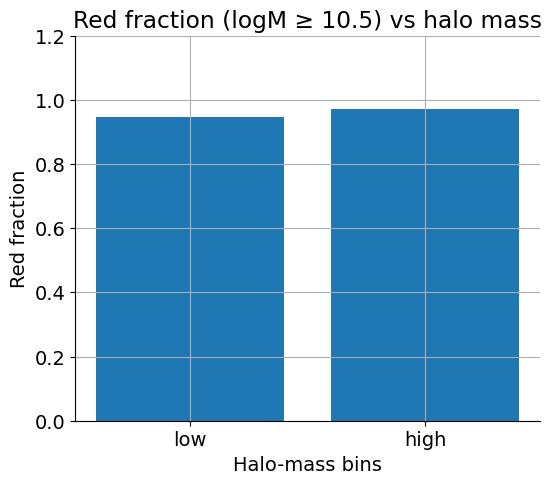

In [12]:

# TODO: Red fraction vs halo mass tertile
M_LIMIT = 10.5
tmp = df_hm[df_hm["log10M"] >= M_LIMIT]
rf = tmp.groupby("hm_bin")["is_red"].mean().reindex(["low", "high"])
fig, ax = plt.subplots()
ax.bar(rf.index.astype(str), rf.values)
ax.set_xlabel("Halo-mass bins")
ax.set_ylabel("Red fraction")
ax.set_ylim(0,1.2)
ax.set_title(f"Red fraction (logM ≥ {M_LIMIT}) vs halo mass")
plt.show()



## 7) Quenching‑efficiency proxy Δ(red fraction) vs mass 
- Compute the difference in red fraction between **high** and **low** halo‑mass bins in sliding mass bins.
- Plot Δ(red fraction) vs `log10M`.
- **Hints**: bin `log10M` (use `LOGM_BINS` or coarser), compute mean of `is_red` in each bin per halo‑mass tertile.


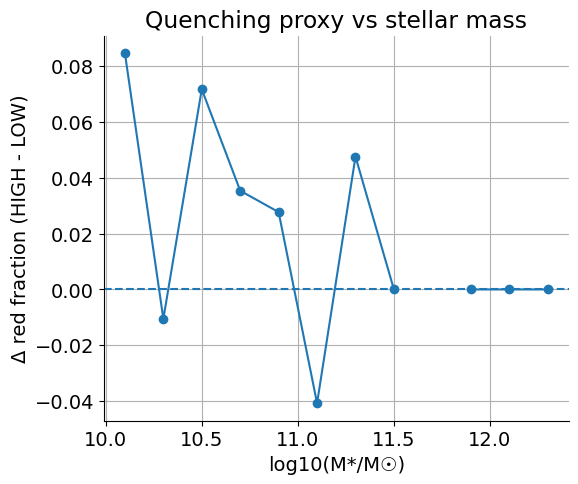

In [13]:

# TODO: Δ(red fraction) vs logM
def red_fraction_in_bins(dfi, bins):
    r = []
    edges = bins
    for i in range(len(edges)-1):
        lo, hi = edges[i], edges[i+1]
        cut = (dfi["log10M"] >= lo) & (dfi["log10M"] < hi)
        if cut.sum() == 0:
            r.append(np.nan)
        else:
            r.append(dfi.loc[cut, "is_red"].mean())
    centers = 0.5*(edges[1:] + edges[:-1])
    return centers, np.array(r)

centers, rf_low = red_fraction_in_bins(df_hm[df_hm["hm_bin"]=="low"], LOGM_BINS)
_, rf_high = red_fraction_in_bins(df_hm[df_hm["hm_bin"]=="high"], LOGM_BINS)
delta = rf_high - rf_low

fig, ax = plt.subplots()
ax.plot(centers, delta, marker="o")
ax.axhline(0, ls="--")
ax.set_xlabel("log10(M*/M☉)")
ax.set_ylabel("Δ red fraction (HIGH - LOW)")
ax.set_title("Quenching proxy vs stellar mass")
plt.show()




## 📝 Report — Red Fraction and Quenching efficiency Proxy
- What does the quenching efficiency proxy code do here?
- Why do you think this is connected to quenching efficiency?
- How is it different than red fraction?
- What did you notice about quenching efficiency from these plots?

_Write your bullets below:_


>


## 8) Cluster “fingerprint” plots 
- For each cluster, create a **3‑panel** figure:  (one example plot is provided. Feel free to adjust/update plot styles)

  (i) CMD with red/blue, (ii) SMF, (iii) red fraction vs mass (coarse bins).
- **Hints**: `matplotlib` subplots; reuse your functions from earlier tasks.


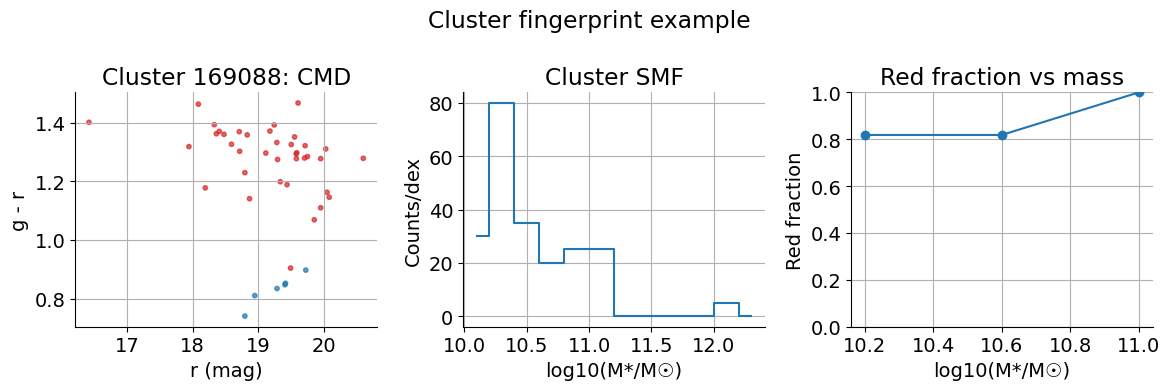

In [14]:

# TODO: Fingerprint for a single cluster (extend this into a loop for several clusters)
target_cluster = df["cluster_id"].iloc[0]
dcl = df[df["cluster_id"] == target_cluster]

fig = plt.figure(figsize=(12,4))

# Panel 1: CMD
ax1 = fig.add_subplot(1,3,1)
ax1.scatter(dcl["r_mag"], dcl["g_r"], s=10, alpha=0.7, c=np.where(dcl["is_red"], "tab:red", "tab:blue"))
ax1.set_xlabel("r (mag)"); ax1.set_ylabel("g - r"); ax1.set_title(f"Cluster {target_cluster}: CMD")

# Panel 2: SMF
ax2 = fig.add_subplot(1,3,2)
cen, phi, _ = compute_smf(dcl["log10M"], LOGM_BINS)
ax2.step(cen, phi, where="mid")
ax2.set_xlabel("log10(M*/M☉)"); ax2.set_ylabel("Counts/dex"); ax2.set_title("Cluster SMF")

# Panel 3: Red fraction vs mass (coarse bins)
coarse = np.arange(max(LOGM_BINS.min(), 9.5), min(LOGM_BINS.max(), 11.8)+0.001, 0.4)
cc, rf = [], []
for lo, hi in zip(coarse[:-1], coarse[1:]):
    mask = (dcl["log10M"]>=lo) & (dcl["log10M"]<hi)
    if mask.sum() > 0:
        rf.append(dcl.loc[mask,"is_red"].mean())
        cc.append(0.5*(lo+hi))
ax3 = fig.add_subplot(1,3,3)
ax3.plot(cc, rf, marker="o")
ax3.set_xlabel("log10(M*/M☉)"); ax3.set_ylabel("Red fraction"); ax3.set_ylim(0,1); ax3.set_title("Red fraction vs mass")

fig.suptitle("Cluster fingerprint example")
plt.tight_layout()
plt.show()


## 9) Outlier hunt
- Identify clusters with unusually high/low red fraction at fixed halo mass.
- Inspect their CMDs/SMFs and suggest possible explanations (data issues, pre‑processing, mergers, selection).
- **Hints**: compute residuals from a simple fit of red fraction vs halo mass; list top/bottom 3 residuals.


,cluster_id,n_gal,med_logM,med_color,red_frac,halo_mass,z,pred_rf,resid_rf
14,990048,55,10.4960,1.158,0.781818,3.290000e+14,0.21550,0.923611,-0.141793
1,446974,52,10.4180,1.153,0.826923,3.360000e+14,0.20405,0.924545,-0.097622
4,955103,52,10.5045,1.310,0.846154,3.920000e+14,0.26750,0.932018,-0.085864


,cluster_id,n_gal,med_logM,med_color,red_frac,halo_mass,z,pred_rf,resid_rf
27,1199939,42,10.5065,1.2935,0.97619,2.640000e+14,0.29540,0.914938,0.061253
28,1206694,42,10.4885,1.6020,1.00000,3.760000e+14,0.33715,0.929883,0.070117
7,976185,41,10.5230,1.5320,1.00000,3.290000e+14,0.33170,0.923611,0.076389


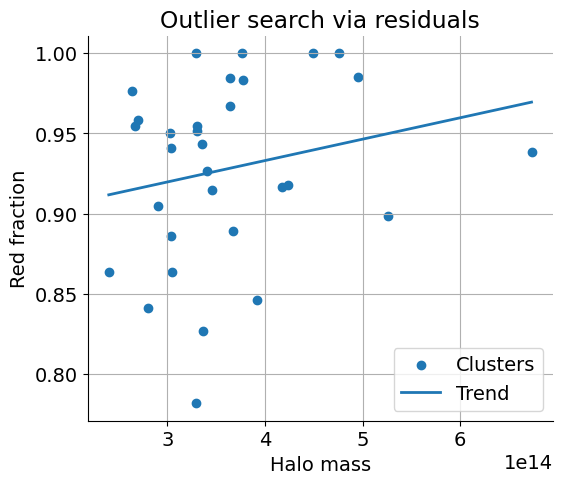

In [15]:

# TODO: Outlier detection by red fraction residuals
if "summary" not in locals():
    M_MIN = 10.0
    d = df[df["log10M"] >= M_MIN].copy()
    summary = (
        d.assign(red=lambda x: x["is_red"].astype(int))
         .groupby("cluster_id")
         .agg(n_gal=("log10M","size"),
              med_logM=("log10M","median"),
              med_color=("g_r","median"),
              red_frac=("red","mean"),
              halo_mass=("halo_mass","median"))
         .reset_index()
    )

# Linear fit: red_frac ~ a*halo_mass + b
X = summary["halo_mass"].values
Y = summary["red_frac"].values
a, b = np.polyfit(X, Y, 1)
summary["pred_rf"] = a*summary["halo_mass"] + b
summary["resid_rf"] = summary["red_frac"] - summary["pred_rf"]

# Show top/bottom outliers
display(summary.sort_values("resid_rf").head(3))
display(summary.sort_values("resid_rf").tail(3))

fig, ax = plt.subplots()
ax.scatter(summary["halo_mass"], summary["red_frac"], label="Clusters")
xx = np.linspace(summary["halo_mass"].min(), summary["halo_mass"].max(), 100)
ax.plot(xx, a*xx + b, label="Trend", lw=2)
ax.set_xlabel("Halo mass")
ax.set_ylabel("Red fraction")
ax.legend(); ax.set_title("Outlier search via residuals")
plt.show()


## 📝 Report 

- Any interesting outliers and plausible interpretations?

_Write your paragraph below:_


> 


## 📝 Report — Reflection (3–5 sentences)
- One limitation of the dataset or your method.
- One astrophysical interpretation you’d like to test with deeper data.

_Write your reflection below:_


> 